In [27]:
import sys
import os

REPO_PATH = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline" # Specify a local path to the repository (or use installed package instead)
os.environ["WANDB_DIR"] = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline"
sys.path.append(REPO_PATH)

from models.mlp import Mlp, mlp_data_preparation
from models.lstm import Lstm, LstmWithAttention, lstm_data_preparation
from models.cnn import Cnn2D, Cnn2D, cnn_data_preparation

import numpy as np
from data.test_train_split import test_train_split
import matplotlib.pyplot as plt
import tensorflow as tf
import json
from models.utils import save_weight_statistics, load_weight_statistics, pen_low_loss
import wandb
from scipy import stats


#### Data preparation

In [87]:
config_data = {
    "months": 3,
    "num_bands": 12,
    "num_buckets": 120,
    "batch_size": 32,
}

dataset_path = rf"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\test_data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_dataset.npy"   
labels_path = rf"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\test_data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_labels.npy"



#### MLP

In [88]:
mlp_dataset, labels = mlp_data_preparation(dataset_path, labels_path)
mlp_train_dataset, mlp_val_dataset, mlp_test_dataset = test_train_split(mlp_dataset,
                                                            labels,
                                                            **config_data)

In [89]:
mlp_dataset.shape


(8616, 4320)

Epoch 1/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 10289.9990 - mae: 80.4754 - mse: 9689.4424 - val_loss: 751627008.0000 - val_mae: 765.5257 - val_mse: 751625792.0000
Epoch 2/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1533.0765 - mae: 26.1092 - mse: 1103.5359 - val_loss: 358126752.0000 - val_mae: 534.4954 - val_mse: 358125216.0000
Epoch 3/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1161.5901 - mae: 22.0464 - mse: 838.4386 - val_loss: 267435168.0000 - val_mae: 463.9218 - val_mse: 267433632.0000
Epoch 4/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1104.6458 - mae: 20.8460 - mse: 775.4131 - val_loss: 221607008.0000 - val_mae: 422.4776 - val_mse: 221605952.0000
Epoch 5/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 997.7953 - mae: 19.8022 - mse: 699.8261 - val_loss: 161516688.0000 - val_mae: 364.2881 - val_mse: 161515552.0000
Epoch 6/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 927.6554 - mae: 18.9892 - mse: 656.0972 - val_loss: 100261992.

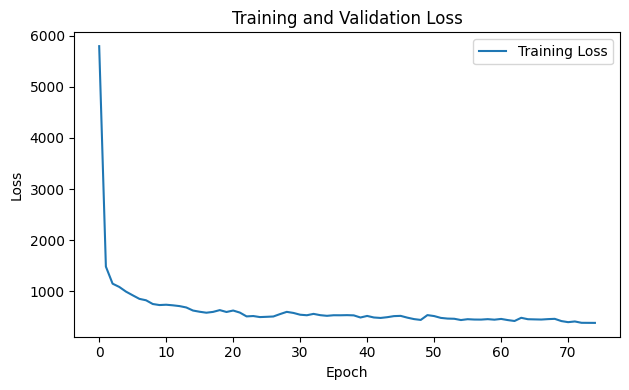

epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mse,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mse,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,74
epoch/learning_rate,0.001
epoch/loss,380.55688


In [90]:

mlp_config = {
    "input_shape": (config_data["months"]
                  * config_data["num_buckets"]
                  * config_data["num_bands"],),
    "no_units": [100,] * 5,
}
mlp_model = Mlp(**mlp_config)
mlp_model.compile(learning_rate=0.00001, loss=pen_low_loss, metrics=["mae", "mse"])
mlp_model.fit(mlp_train_dataset,
         mlp_val_dataset,
         epochs=300)

# After training
original_weights = [w.numpy() for w in mlp_model.weights]

mlp_model.trainable = False
wandb.finish()  

In [91]:
mlp_eval = mlp_model.evaluate(mlp_test_dataset)
print(mlp_eval)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2090.5483 - mae: 22.5753 - mse: 981.9237 
[1862.623779296875, 22.60862159729004, 959.560791015625]


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


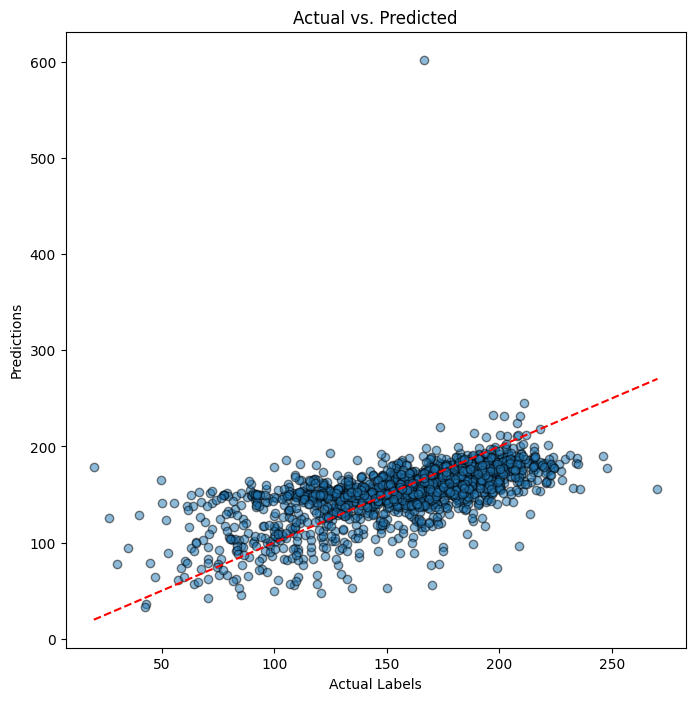

In [92]:
mlp_predictions = mlp_model.predict(mlp_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in mlp_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, mlp_predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

In [93]:
test_responses = []
for _, response in mlp_test_dataset:
    test_responses.append(response.numpy())

test_responses = np.concatenate(test_responses, axis=0)

mean_train_response = tf.reduce_mean([y for _, y in mlp_train_dataset]).numpy()

baseline_loss = sum(((mean_train_response - test_responses) ** 2)/len(test_responses))
print(sum(baseline_loss))


1423.0811767578125


#### LSTM

In [94]:
lstm_dataset, labels = lstm_data_preparation(dataset_path, labels_path)
lstm_train_dataset, lstm_val_dataset, lstm_test_dataset = test_train_split(lstm_dataset,
                                                                            labels,
                                                                            **config_data)

Epoch 1/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 18251.5898 - mae: 128.2055 - val_loss: 6769.2666 - val_mae: 74.4191
Epoch 2/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 5380.0244 - mae: 65.1356 - val_loss: 2436.4421 - val_mae: 41.6584
Epoch 3/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 2083.1440 - mae: 38.7254 - val_loss: 1582.6539 - val_mae: 32.5077
Epoch 4/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 1459.0988 - mae: 31.4596 - val_loss: 1494.0958 - val_mae: 31.0187
Epoch 5/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 1388.8199 - mae: 30.0663 - val_loss: 1497.5278 - val_mae: 30.8809
Epoch 6/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 1382.8073 - mae: 29.8172 - val_loss: 1504.5673 - val_mae: 30.8994
Epoch 7/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 1386.6462 - mae: 29.7996 - val_loss: 1501.2719 - val_mae: 30.8569
Epoch 8/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 1383.4478 - mae: 29.7722 - val_loss: 15

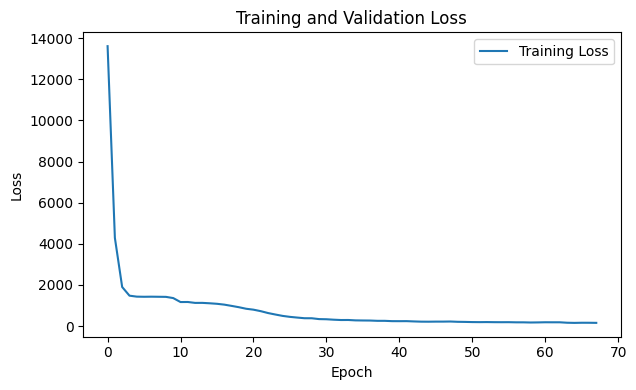

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,67
epoch/learning_rate,0.001
epoch/loss,154.28735
epoch/mae,7.0702
epoch/val_loss,762.95746


In [95]:
train_lstm = True
model_path = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\models\saved\\"
model_name = "LSTM-angry-mayo-20241101-102955.keras"
if train_lstm:
    wandb.init(project="blue-marble")
    config_lstm = {
        "input_shape": (config_data["months"], config_data["num_buckets"] * config_data["num_bands"]),
        "no_lstm_units": [200,] * 7,
        "attention_units": 200,
    }
    lstm_model = LstmWithAttention(**config_lstm)
    lstm_model.compile(learning_rate=0.0001)
    lstm_model.fit(lstm_train_dataset,
            lstm_val_dataset,
            epochs=300)

    lstm_model.trainable = False
    wandb.finish()
else:
    lstm_model = tf.keras.models.load_model(model_path + model_name)
    lstm_model.compile()

In [96]:
lstm_eval = lstm_model.evaluate(lstm_test_dataset)
print(lstm_eval)

print(f"LSTM detalis: {lstm_model.summary()}")


 1/53 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 833.1957 - mae: 20.7136

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 684.1239 - mae: 19.9847
[693.6210327148438, 20.289669036865234]


Model: "lstm_with_attention_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (32, 3, 200)           │     1,312,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_3               │ ?                      │        80,601 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (32, 1)                │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,955,808 (37.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,318,602 (12.66 MB)

 Optimizer params: 6,637,206 (25.32 MB)

LSTM detalis: None


#### CNN

In [97]:
cnn_dataset, labels = cnn_data_preparation(dataset_path, labels_path, **config_data)
cnn_train_dataset, cnn_val_dataset, cnn_test_dataset = test_train_split(cnn_dataset,
                                                                            labels,
                                                                            **config_data)

In [98]:
print(config_data["months"], config_data["num_buckets"], config_data["num_bands"], sep=", ")


3, 120, 12


Epoch 1/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 10481.6963 - mae: 81.3109 - val_loss: 1395.3330 - val_mae: 30.2640
Epoch 2/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1318.4387 - mae: 28.9027 - val_loss: 1323.0237 - val_mae: 27.5241
Epoch 3/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1181.5089 - mae: 27.0880 - val_loss: 1332.6056 - val_mae: 27.2969
Epoch 4/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1113.6721 - mae: 26.2752 - val_loss: 1321.2410 - val_mae: 27.1697
Epoch 5/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1065.4550 - mae: 25.7170 - val_loss: 1308.0396 - val_mae: 27.1585
Epoch 6/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 994.3911 - mae: 24.7646 - val_loss: 1168.0609 - val_mae: 25.7738
Epoch 7/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 881.3088 - mae: 23.1380 - val_loss: 989.7158 - val_mae: 23.8625
Epoch 8/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 790.1672 - mae: 21.7867 - val_loss: 918.9555

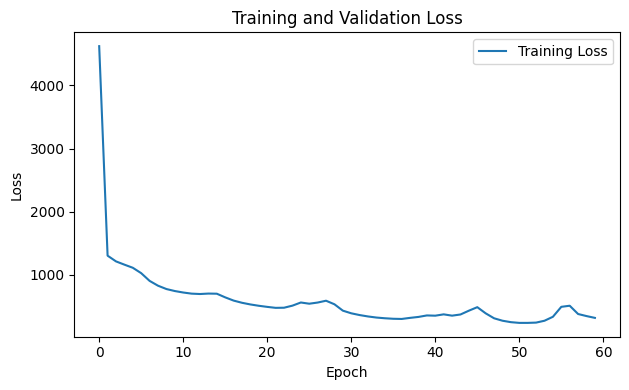

epoch/epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▂▂▂▁
epoch/val_loss,█▇▇▇▇▄▃▃▃▂▆▄▃▃▂▂▂█▂▄▂▂▂▂▂▁▁▁▂▁▃▃▃▃▂▂▄▁▃▁
epoch/val_mae,█▆▆▅▄▃▃▂▃▅▃▃▂▂▂▂▂█▄▂▃▃▂▂▂▁▂▁▆▁▁▂▄▃▃▂▂▅▁▁
epoch/epoch,59
epoch/learning_rate,0.001
epoch/loss,318.24863
epoch/mae,13.49545
epoch/val_loss,705.04053


In [99]:
wandb.init(project="blue-marble")
config_cnn = {
    "input_shape": (config_data["months"], config_data["num_buckets"], config_data["num_bands"]),
    "conv_filters": [32, 64, 128],
    "dense_units": [100] * 6,
    "conv_kernel_size": (1, 3),
    "pool_size": (1, 2)
}
cnn_model = Cnn2D(**config_cnn)
cnn_model.compile(learning_rate=0.00001)
cnn_model.fit(cnn_train_dataset,
        cnn_val_dataset,
        epochs=300)

cnn_model.trainable = False
wandb.finish()

In [100]:
cnn_eval = cnn_model.evaluate(cnn_test_dataset)
print(cnn_eval)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 622.2701 - mae: 19.2177
[634.4354248046875, 19.429502487182617]


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


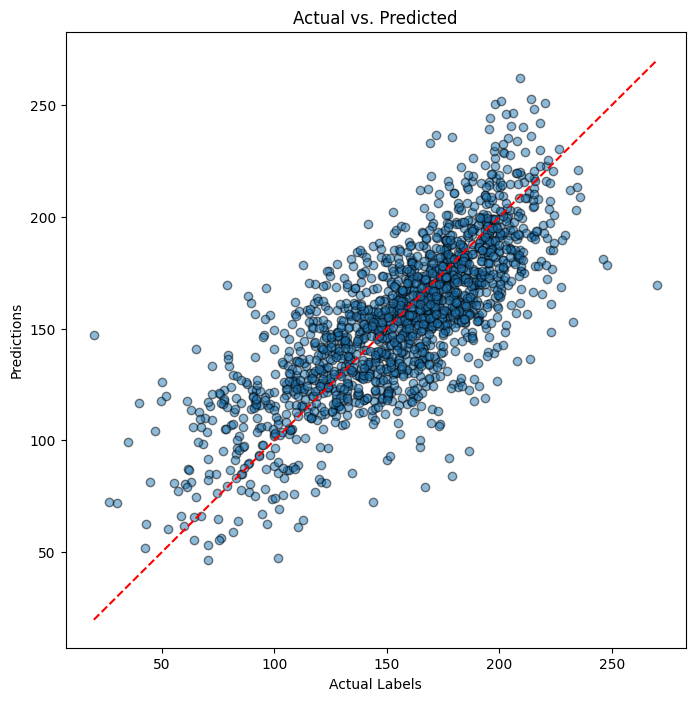


Correlations using scipy.stats.pearsonr:
CNN correlation: 0.759 (p-value: 0.000e+00)


Model: "Cnn2D-weary-coffee-20241103-083205"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (32, 3, 118, 32)       │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (32, 3, 57, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (32, 3, 26, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (32, 3, 59, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (32, 3, 28, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (32, 3, 13, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (32, 4992)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (32, 100)              │       499,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (32, 100)              │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (32, 100)              │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (32, 100)              │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (32, 100)              │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (32, 100)              │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (32, 100)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (32, 1)                │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,745,993 (6.66 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 581,997 (2.22 MB)

 Optimizer params: 1,163,996 (4.44 MB)

CNN detalis: None


In [101]:
cnn_predictions = cnn_model.predict(cnn_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in cnn_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, cnn_predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

cnn_corr, cnn_p = stats.pearsonr(actual_labels.flatten(), cnn_predictions.flatten())
print("\nCorrelations using scipy.stats.pearsonr:")
print(f"CNN correlation: {cnn_corr:.3f} (p-value: {cnn_p:.3e})")

print(f"CNN detalis: {cnn_model.summary()}")


#### Comparison

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


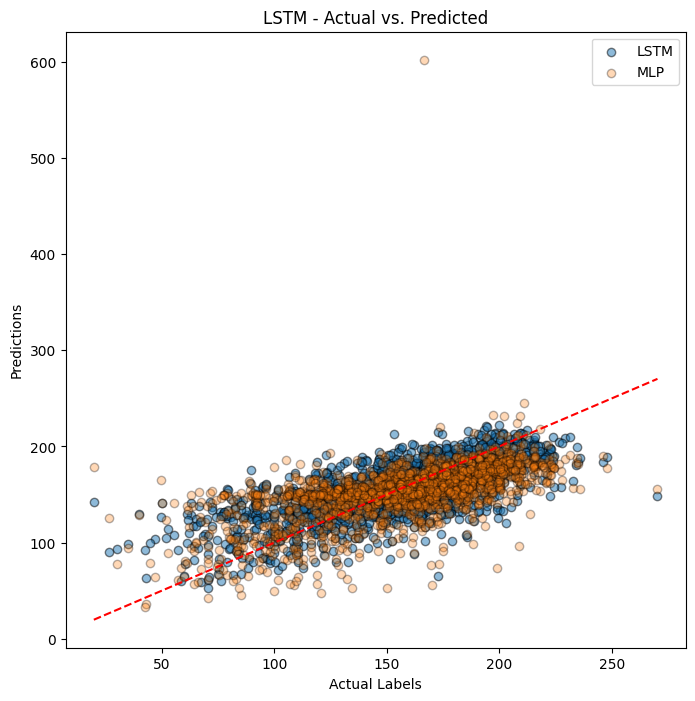


Correlations using scipy.stats.pearsonr:
MLP correlation: 0.608 (p-value: 0.000e+00)
LSTM correlation: 0.719 (p-value: 0.000e+00)
CNN correlation: 0.759 (p-value: 0.000e+00)
Mean of actual labels: 155.66


In [108]:
lstm_predictions = lstm_model.predict(lstm_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in lstm_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, lstm_predictions, alpha=0.5, edgecolors='k', label="LSTM")
plt.scatter(actual_labels, mlp_predictions, alpha=0.3, edgecolors='k', label="MLP")
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('LSTM - Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.legend()
plt.show()

mlp_corr, mlp_p = stats.pearsonr(actual_labels.flatten(), mlp_predictions.flatten())
lstm_corr, lstm_p = stats.pearsonr(actual_labels.flatten(), lstm_predictions.flatten())
cnn_corr, cnn_p = stats.pearsonr(actual_labels.flatten(), cnn_predictions.flatten())
print("\nCorrelations using scipy.stats.pearsonr:")
print(f"MLP correlation: {mlp_corr:.3f} (p-value: {mlp_p:.3e})")
print(f"LSTM correlation: {lstm_corr:.3f} (p-value: {lstm_p:.3e})")
print(f"CNN correlation: {cnn_corr:.3f} (p-value: {cnn_p:.3e})")

print(f"Mean of actual labels: {np.mean(actual_labels):.2f}")



In [103]:
# loss below treshold
low_yield_treshold = 100
low_yeild_mask = actual_labels < low_yield_treshold

low_yield_labels = actual_labels[low_yeild_mask]
mlp_low_predictions = mlp_predictions[low_yeild_mask]
lstm_low_predictions = lstm_predictions[low_yeild_mask]
cnn_low_predictions = cnn_predictions[low_yeild_mask]

mlp_mse_low = sum((mlp_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)
lstm_mse_low = sum((lstm_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)
cnn_mse_low = sum((cnn_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)

print(f"MLP RMSE low yield: {np.sqrt(mlp_mse_low):.2f}")
print(f"LSTM RMSE low yield: {np.sqrt(lstm_mse_low):.2f}")
print(f"CNN RMSE low yield: {np.sqrt(cnn_mse_low):.2f}")
print(f"Low yield %: {float(np.sum(low_yeild_mask)/len(low_yeild_mask)):.2%}")


MLP RMSE low yield: 14.31
LSTM RMSE low yield: 13.41
CNN RMSE low yield: 10.80
Low yield %: 8.84%


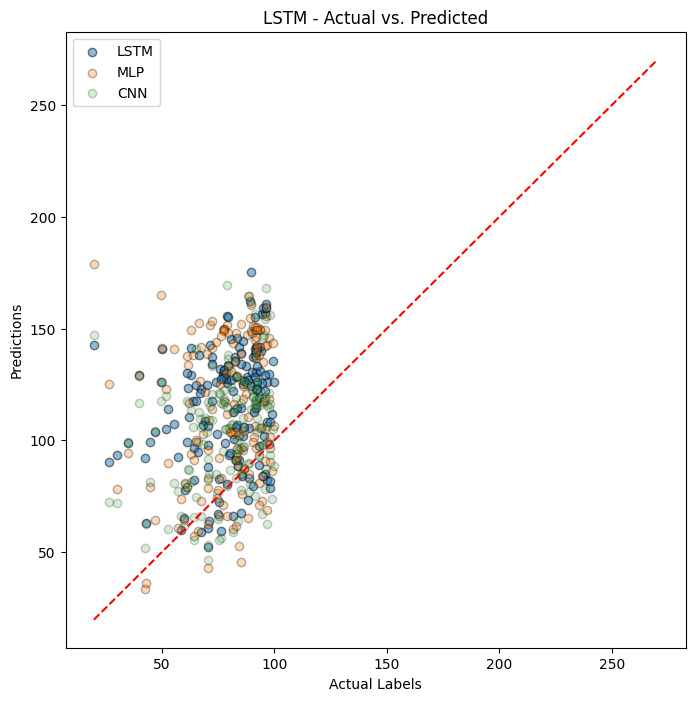

In [104]:
# Plot low yield actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(low_yield_labels, lstm_low_predictions, alpha=0.5, edgecolors='k', label="LSTM")
plt.scatter(low_yield_labels, mlp_low_predictions, alpha=0.3, edgecolors='k', label="MLP")
plt.scatter(low_yield_labels, cnn_low_predictions, alpha=0.2, edgecolors='k', label="CNN")
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('LSTM - Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.legend()
plt.show()

#### Residuals

C:\Users\tskor\AppData\Local\Temp\ipykernel_9804\3428180465.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(residuals_for_plot, labels=labels)


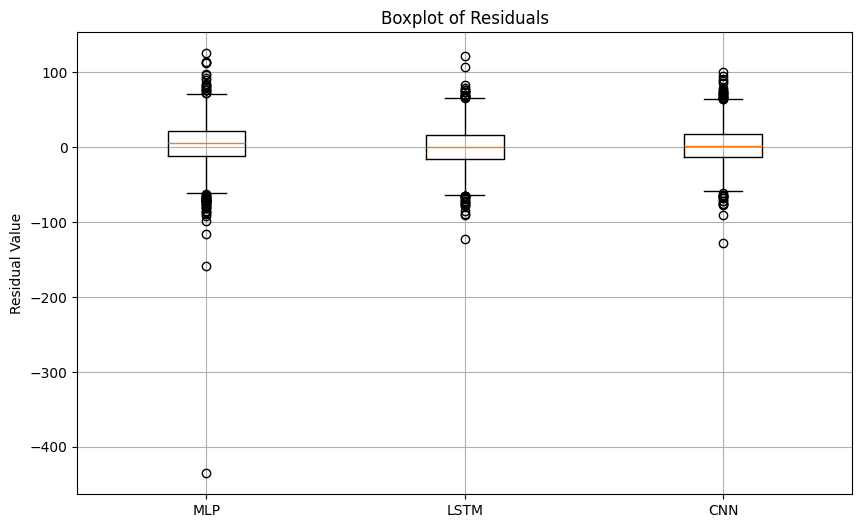

In [105]:
residuals = [actual_labels - x for x in [mlp_predictions, lstm_predictions, cnn_predictions]]
residuals_for_plot = [residual.flatten() for residual in residuals]

labels = ["MLP", "LSTM", "CNN"]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals_for_plot, labels=labels)
plt.title('Boxplot of Residuals')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()


Comment: 
* MLP using weighted loss function has marginally better performance on low yield data but also the highest variance
* 
* Residuals for all models are symetrical and have mean close to 0 but they are likely not normally distributed

* Potential further improvement could come from data augmentation


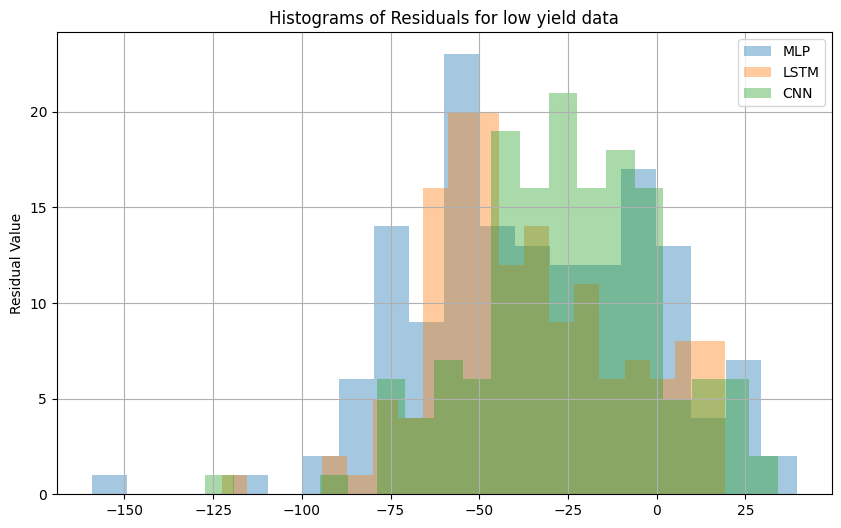

In [118]:
residuals_low_yield = [low_yield_labels - x for x in [mlp_low_predictions, lstm_low_predictions, cnn_low_predictions]]
residuals_for_plot = [residual.flatten() for residual in residuals_low_yield]

labels = ["MLP", "LSTM", "CNN"]

plt.figure(figsize=(10, 6))
for i, residual in enumerate(residuals_for_plot):
    plt.hist(residuals_for_plot[i], bins=20, alpha=0.4, label=labels[i])
    
plt.title('Histograms of Residuals for low yield data')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.show()

#### LSTM investigation

In [106]:
lstm_model.model_name

In [107]:
import tensorflow as tf
import json

def inspect_keras_model(path):
    # Load the model
    model = tf.keras.models.load_model(path)
    
    print("\n=== Basic Model Info ===")
    print(f"Number of layers: {len(model.layers)}")
    print(f"Input shape: {model.input_shape}")
    print(f"Output shape: {model.output_shape}")
    
    print("\n=== Model Summary ===")
    model.summary()
    
    print("\n=== Detailed Layer Info ===")
    for layer in model.layers:
        print(f"\nLayer: {layer.name}")
        print(f"  Type: {type(layer).__name__}")
        print(f"  Input shape: {layer.input_shape}")
        print(f"  Output shape: {layer.output_shape}")
        print(f"  Trainable: {layer.trainable}")
        print(f"  Number of weights: {len(layer.weights)}")
        
        # Print weight details
        if layer.weights:
            print("  Weights:")
            for weight in layer.weights:
                print(f"    {weight.name}: shape {weight.shape}")
    
    print("\n=== Optimizer Info ===")
    if model.optimizer:
        print(f"Optimizer: {type(model.optimizer).__name__}")
        print("Optimizer config:")
        print(json.dumps(model.optimizer.get_config(), indent=2))
    
    print("\n=== Compilation Info ===")
    if hasattr(model, 'loss'):
        print(f"Loss: {model.loss}")
    if hasattr(model, 'metrics'):
        print(f"Metrics: {model.metrics}")

lstm_model.name
model_path = rf"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\models\saved\{lstm_model.model_name}.keras"
inspect_keras_model(model_path)

TypeError: <class 'models.lstm.LstmWithAttention'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'models.lstm', 'class_name': 'LstmWithAttention', 'config': {'name': 'lstm_with_attention_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'input_shape': [3, 1440], 'no_lstm_units': [200, 200, 200, 200, 200, 200, 200], 'attention_units': 200}, 'registered_name': 'LstmWithAttention', 'build_config': {'input_shape': [32, 3, 1440]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'mse', 'loss_weights': None, 'metrics': ['mae'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: LstmWithAttention.__init__() got an unexpected keyword argument 'trainable'

In [10]:
model = tf.keras.models.load_model(model_path)

In [11]:
def inspect_weight_statistics(model):
    for layer in model.layers:
        if layer.weights:
            print(f"\nLayer: {layer.name}")
            for weight in layer.weights:
                values = weight.numpy()
                print(f"\nWeight: {weight.name}")
                print(f"Shape: {values.shape}")
                print(f"Mean: {np.mean(values):.6f}")
                print(f"Std: {np.std(values):.6f}")
                print(f"Min: {np.min(values):.6f}")
                print(f"Max: {np.max(values):.6f}")
                # Check if weights follow specific distribution
                print("Distribution characteristics:")
                if np.abs(np.mean(values)) < 0.1 and 0.4 < np.std(values) < 0.8:
                    print("  Possibly Glorot/Xavier initialization")
                elif np.abs(np.mean(values)) < 0.1 and np.std(values) < 0.4:
                    print("  Possibly He/Kaiming initialization")

In [12]:
inspect_weight_statistics(lstm_model)


Layer: lstm_1

Weight: kernel
Shape: (540, 440)
Mean: 0.000968
Std: 0.134310
Min: -1.047605
Max: 0.942149
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: recurrent_kernel
Shape: (110, 440)
Mean: -0.000418
Std: 0.160613
Min: -0.988930
Max: 1.121738
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: bias
Shape: (440,)
Mean: 0.266560
Std: 0.432170
Min: -0.231943
Max: 1.232651
Distribution characteristics:

Layer: lstm_2

Weight: kernel
Shape: (110, 440)
Mean: -0.001006
Std: 0.170689
Min: -0.774974
Max: 0.835811
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: recurrent_kernel
Shape: (110, 440)
Mean: -0.000890
Std: 0.116206
Min: -0.681109
Max: 0.615305
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: bias
Shape: (440,)
Mean: 0.208311
Std: 0.425549
Min: -0.336598
Max: 1.111011
Distribution characteristics:

Layer: lstm_3

Weight: kernel
Shape: (110, 440)
Mean: -0.000897
Std: 0.172648


In [13]:
lstm_weights_path = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\models\saved\good_lstm_weights"
save_weight_statistics(lstm_model, lstm_weights_path)

Weight statistics saved to: C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\models\saved\good_lstm_weights/weight_stats_LSTM-weary-beer-20241031-230908_20241031-233034.json


{'model_name': 'LSTM-weary-beer-20241031-230908',
 'timestamp': '20241031-233034',
 'layers': [{'layer_name': 'lstm_1',
   'layer_type': 'LSTM',
   'weights': [{'weight_name': 'kernel',
     'shape': [540, 440],
     'statistics': {'mean': 0.0009684133692644536,
      'std': 0.13431040942668915,
      'min': -1.0476053953170776,
      'max': 0.9421489238739014,
      'median': 0.0011091433698311448,
      'quartiles': [-0.08583041653037071, 0.08747386559844017]},
     'likely_initialization': 'possibly_he'},
    {'weight_name': 'recurrent_kernel',
     'shape': [110, 440],
     'statistics': {'mean': -0.00041752035031095147,
      'std': 0.16061250865459442,
      'min': -0.9889298677444458,
      'max': 1.1217381954193115,
      'median': 0.0006034302059561014,
      'quartiles': [-0.10405119322240353, 0.10277333669364452]},
     'likely_initialization': 'possibly_he'},
    {'weight_name': 'bias',
     'shape': [440],
     'statistics': {'mean': 0.266560435295105,
      'std': 0.43216

In [ ]:
load_weight_statistics